# Práctica 1: Adquirir y analizar datos de ChEMBL

## Conceptos a trabajar
**Uniprot:** Es una base de datos que busca proporcionar a la comunidad científica un recurso integral, de alta calidad y de libre acceso de secuencias de proteínas e información funcional. Referencia: [Uniprot](https://www.uniprot.org/).

**ChEMBL:** Es una base de datos que contiene moléculas bioactivas, reune datos químicos, de bioactividad y genómicos. Refernecia: [ChEMBL](https://www.ebi.ac.uk/chembl/)

**Half-maximal inhibitory concentration (IC50):** Expresa la cantidad de fármaco necesaria para inhibir un proceso biológico a la mitad del valor no inhibido, es la medida más utilizada de la eficacia o potencia de un fármaco. Referencia: [Aykul, S. y Martínez-Hackert, E. (2016)](https://doi.org/10.1016/j.ab.2016.06.025)

**pIC50:** Es el logaritmo negativo en base diez del IC50, cuando las unidades de son **molares (M)**. Se usa para facilitar la comparación entre distintos IC50. También, es importante saber que a mayor pIC50 el fármaco tiene una mayor eficacia o mayor potencial.

**Half maximal effective concentration (EC50):** Es la concentración efectiva para producir el 50 % de la respuesta máxima, se usa para comparar las potencias de los fármacos. También, es importante saber que a menor sea el EC50 más potente será el fármaco. A esta pedida también se le calcula el logaritmo negativo en base diez **(pEC50)** para facilitar su comprensión. Referencia: [Waller, D., & Sampson, A. (2018)](https://doi.org/10.1016/B978-0-7020-7167-6.00001-4)

**Inhibitor constant (Ki):** Es la concentración requerida para producir la mitad de la inhibición máxima, es útil para describir la afinidad de unión de una molécula a un receptor.

**SMILES (Simplified Molecular-Input Line-Entry System):** Es una notación de línea para describir estructuras químicas utilizando cadenas ASCII cortas. Referencia: [Daylight Chemical Information Systems](https://www.daylight.com/smiles/)

# Proteína a estudiar
**UniprotID**: P49841
**Name**: Glycogen synthase kinase-3 beta
**Protein Target Classification**: Enzyme > Kinase > Protein Kinase > CMGC protein kinase group > CMGC protein kinase GSK family

Debemos buscar el ID del target de interes en la base de datos Uniprot, que en este caso es Glucógeno sintasa quinasa-3 beta, ID: [P49841](https://www.uniprot.org/uniprot/P49841).

In [141]:
# Librería necesaria para comunicarse con CHEMBL
from chembl_webresource_client.new_client import new_client
# libreria para trabajar con base de datos (Dataframes)
import pandas as pd

# Declaración de variables para instanciar el cliente de CHEMBL y acceder a la base de datos
targets = new_client.target
compounds = new_client.molecule
bioactivities = new_client.activity

In [142]:
uniprot_id = 'P49841'
# Adquirir información de ChEMBL que sea de interés
target_P49841 = targets.get(target_components__accession=uniprot_id) \
                       .only('target_chembl_id', 'organism', 'pref_name', 'target_type')
pd.DataFrame(target_P49841)

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Glycogen synthase kinase-3 beta,CHEMBL262,SINGLE PROTEIN
1,Homo sapiens,Glycogen synthase kinase-3,CHEMBL2095188,PROTEIN FAMILY
2,Homo sapiens,Axin-1/Glycogen synthase kinase-3 beta,CHEMBL3883309,PROTEIN-PROTEIN INTERACTION


Vamos a seleccionar el target de interés (`CHEMBL262`) y guardar el ChEMBL-ID

In [143]:
# Seleccionar el target de interes
target = target_P49841[0]
print(target)
# Guardar el ChEMBL-ID
chembl_id = target['target_chembl_id']
print(f'ChEMBL ID: {chembl_id}')

{'organism': 'Homo sapiens', 'pref_name': 'Glycogen synthase kinase-3 beta', 'target_chembl_id': 'CHEMBL262', 'target_type': 'SINGLE PROTEIN'}
ChEMBL ID: CHEMBL262


## Datos de bioactividad

Ahora consultamos los datos de bioactividad que son de interés. Los pasos a seguir son:
1. Descargar y filtrar bioactividades para el target
    Los datos de bioactividad se van a filtrar de la siguiente manera:
        * Tipo de bioactividad: IC50, EC50, Ki
        * Relación: "="
2. Convertir los datos descargados en un data frame:
    Las columnas de interés son: `molecule_chembl_id`, `type`, `relation`, `pchembl_value`

In [144]:
# Primero, descargamos toda la base de datos
bioact_temp = bioactivities.filter(target_chembl_id = chembl_id)\
                      .filter(relation = '=') \
                      .only('molecule_chembl_id', 'type', 'relation', 'standar_value', 'standar_units', 'pchembl_value', )
df_bioact_temp = pd.DataFrame(bioact_temp)
# se organizan las columnas
df_bioact_temp = df_bioact_temp[['molecule_chembl_id', 'type', 'relation', 'value', 'units', 'pchembl_value']]
df_bioact_temp
# La primera vez que se ejecuta esta celda celda puede tardar ~5-10 minutos

,molecule_chembl_id,type,relation,value,units,pchembl_value
0,CHEMBL322970,IC50,=,0.38,uM,6.42
1,CHEMBL322970,EC50,=,45.6,uM,4.34
2,CHEMBL322970,EC50,=,30.62,uM,4.51
3,CHEMBL322970,Fold stimulation,=,1.3,None,None
4,CHEMBL112564,IC50,=,6.92,uM,5.16
...,...,...,...,...,...,...
6863,CHEMBL102714,IC50,=,0.028999999999999998,uM,7.54
6864,CHEMBL4868123,INH,=,13.0,%,None
6865,CHEMBL156277,IC50,=,14.0,nM,7.85
6866,CHEMBL4875188,IC50,=,36.0,nM,7.44


Ya que la columna *realtion* tiene solo un tipo (esto se debe al filtro incial de la base de datos), podemos quitarla:

In [145]:
df_bioact_temp.pop('relation')
df_bioact_temp.head()

,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL322970,IC50,0.38,uM,6.42
1,CHEMBL322970,EC50,45.6,uM,4.34
2,CHEMBL322970,EC50,30.62,uM,4.51
3,CHEMBL322970,Fold stimulation,1.3,None,None
4,CHEMBL112564,IC50,6.92,uM,5.16


# Explorar los datos adquiridos
## Tipo de actividad
Podemos ver el tipo de actividad descargada (filtrar por _type_)

In [146]:
df_bioact_temp.type.value_counts()

IC50                      2707
Inhibition                 889
INH                        877
pKi                        620
Activity                   437
Residual Activity          316
Ki                         289
pIC50                      262
Thermal melting change     156
EC50                        69
AC50                        39
Kd                          35
deltaT                      27
IZ                          26
deltaTm                     26
Kd apparent                 25
AC50_uM                     20
Residual activity            9
Vmax                         8
Km                           8
Efficacy                     7
Fold stimulation             4
Residual_activity            3
IC                           3
Ratio                        1
Inihibition                  1
Selectivity ratio            1
Log IC50                     1
Specific activity            1
Ratio IC50                   1
Name: type, dtype: int64

O realizar rápidamente un gráfico con la información filtrada

<AxesSubplot: >

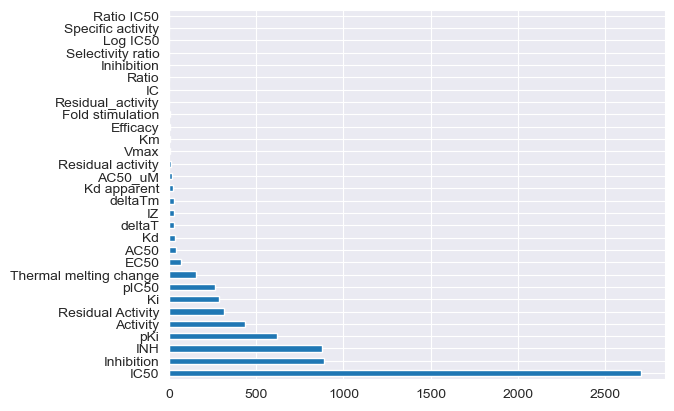

In [147]:
df_bioact_temp.type.value_counts().plot.barh()

Ahora, supongamos que queremos filtrar solamente la actividad **IC50**, **EC50** y **KI**

In [148]:
# Luego, filtramos por el tipo de actividad deseada
df_bioact = df_bioact_temp[(df_bioact_temp['type'] == 'IC50') |
                           (df_bioact_temp['type'] == 'EC50') |
                           (df_bioact_temp['type'] == 'Ki')]
print(f'Total de datos cargados: {len(df_bioact)}')
# primeros compuestos del dataframe
df_bioact.head()

Total de datos cargados: 3065


,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL322970,IC50,0.38,uM,6.42
1,CHEMBL322970,EC50,45.6,uM,4.34
2,CHEMBL322970,EC50,30.62,uM,4.51
4,CHEMBL112564,IC50,6.92,uM,5.16
5,CHEMBL321421,IC50,0.41,uM,6.39


In [149]:
grupo_actividad = df_bioact.type.value_counts()
grupo_actividad

IC50    2707
Ki       289
EC50      69
Name: type, dtype: int64

<AxesSubplot: >

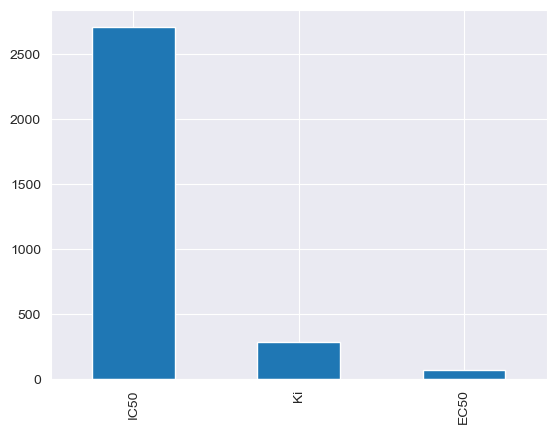

In [150]:
grupo_actividad.plot.bar()

## Unidades de medición
Ahora exploremos un poco las unidades de medición de la bioactividad

In [151]:
grupo_unidades = df_bioact.units.value_counts(dropna=False)
grupo_unidades

uM        1593
nM        1425
microM      34
mM           7
M            1
pM           1
umol/L       1
nmol/L       1
10'-9M       1
10^-9M       1
Name: units, dtype: int64

<AxesSubplot: >

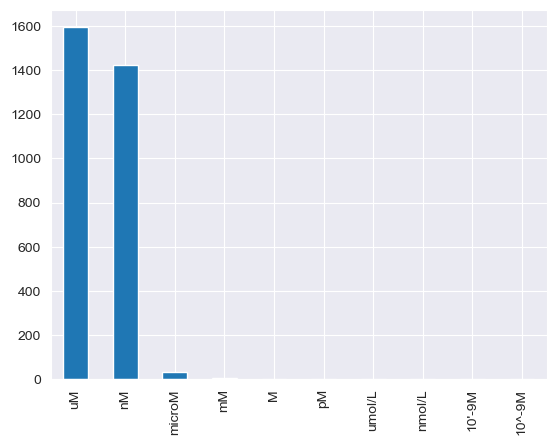

In [152]:
grupo_unidades.plot.bar()

## Limpiar los datos
Es posible que algunos compuestos tengan valores faltantes y también duplicados, ya que el mismo compuesto puede haber sido probado más de una vez (nosotros nos quedaremos solo con el que primero haya sido probado)

In [153]:
# Primero verificamos cuantos compuestos tenemos en total
ori_len = len(df_bioact)
print(f'Total de compuestos originales es: {ori_len}')

Total de compuestos originales es: 3065


In [154]:
# Se eliminan los compuestos que no tienen pChEMBL_value
df_bioact = df_bioact.dropna(axis=0, how = 'any')
new_len = len(df_bioact)
print(f'Total de compuestos despues de eliminar aquellos con datos faltantes: {new_len}')
# Se le resta al número total de compuestos el número total de compuestos al eliminar los que no tienen pChEMBL_value
print(f'Total compuestos eliminados {ori_len - new_len}')
ori_len = new_len

Total de compuestos despues de eliminar aquellos con datos faltantes: 3042
Total compuestos eliminados 23


In [155]:
# Se eliminan los compuestos duplicados y nos quedamos con el primer compuesto de la lista
df_bioact = df_bioact.drop_duplicates('molecule_chembl_id', keep = 'first')
new_len = len(df_bioact)
print(f'Total de compuestos sin duplicados : {new_len}')
# Se le resta al número total de compuestos al eliminar los que no tienen pChEMBL_value el número total de compuestos sin duplicados
print(f'Total compuestos eliminados {ori_len - new_len}')
ori_len = new_len

Total de compuestos sin duplicados : 2605
Total compuestos eliminados 437


Ahora que hemos eliminado algunas filas restableceremos el índice para que este sea continuo

In [156]:
# El ínidce tiene saltos
df_bioact.head()

,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL322970,IC50,0.38,uM,6.42
4,CHEMBL112564,IC50,6.92,uM,5.16
5,CHEMBL321421,IC50,0.41,uM,6.39
6,CHEMBL388978,IC50,0.16,uM,6.80
8,CHEMBL115875,IC50,9.6,uM,5.02


In [157]:
df_bioact.reset_index(drop=True, inplace=True)
df_bioact.head()

,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL322970,IC50,0.38,uM,6.42
1,CHEMBL112564,IC50,6.92,uM,5.16
2,CHEMBL321421,IC50,0.41,uM,6.39
3,CHEMBL388978,IC50,0.16,uM,6.80
4,CHEMBL115875,IC50,9.6,uM,5.02


## Histograma del pchembl_value
La columna `pchembl_value` maneja un valor _común_ el cual se puede analizar un poco.
Antes de realizar el histograma debemos cambiar el tipo de la variable, pues esta como `string`

In [158]:
# Primer valor:
value = df_bioact.pchembl_value[0]
print(value, type(value))

6.42 <class 'str'>


Colo la columna `pchembl_value` tiene valores como texto, se deben convetir a valores numéricos

In [159]:
# Cambiar de str a float la columna pchembl_value
df_bioact = df_bioact.astype({'pchembl_value': 'float'})
value = df_bioact.pchembl_value[0]
print(value, type(value))

6.42 <class 'numpy.float64'>


In [160]:
df_bioact.dtypes

molecule_chembl_id     object
type                   object
value                  object
units                  object
pchembl_value         float64
dtype: object

Ahora se puede hacar el instograma de los valores de la columna `pchembl_value`

array([[<AxesSubplot: title={'center': 'pchembl_value'}>]], dtype=object)

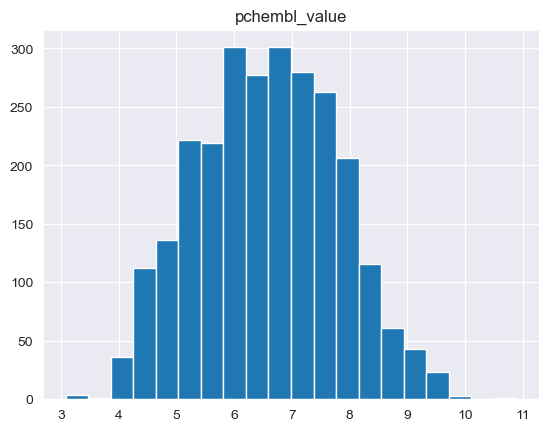

In [161]:
df_bioact.hist(column='pchembl_value', bins=20)

## Organizar los datos
Vamos a organizar el DataFrame de mayor a menor pchembl_value.

In [162]:
# Organizamos de mayor a menor pchembl_value
df_bioact.sort_values(by="pchembl_value", ascending=False, inplace=True)
# Restablecemos el índice
df_bioact.reset_index(drop=True, inplace=True)
# Imprimimos los primeros datos del Dataframe
df_bioact.head()

,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL2386094,IC50,0.013,nM,10.89
1,CHEMBL4084855,IC50,0.1,nM,10.00
2,CHEMBL3895998,IC50,0.1,nM,10.00
3,CHEMBL564450,IC50,0.00014,uM,9.85
4,CHEMBL4077376,IC50,0.2,nM,9.70


## Guardar y cargar los datos
Para continuar usando el Data Frame en la práctica sin necesidad de siempre estarnos conectando a ChEMBL, vamos a guardar el Data Frame obtenido como un archivo separado por comas (data/compuestos_uniprot_id.csv)

In [163]:
df_bioact.to_csv(f"./data/compuestos_{uniprot_id}.csv", index=0)

En adelante, si queremos utilizar el Dataframe, podemos cargar el archivo guardado

In [164]:
df_bioact = pd.read_csv(f"data/compuestos_{uniprot_id}.csv")
df_bioact.head()

,molecule_chembl_id,type,value,units,pchembl_value
0,CHEMBL2386094,IC50,0.01300,nM,10.89
1,CHEMBL4084855,IC50,0.10000,nM,10.00
2,CHEMBL3895998,IC50,0.10000,nM,10.00
3,CHEMBL564450,IC50,0.00014,uM,9.85
4,CHEMBL4077376,IC50,0.20000,nM,9.70


# Datos de los compuestos

A continuación vamos a obtener los datos de las moléculas que estan almacenados dentro de cada molecule_chembl_id

In [165]:
# Librería necesaria para comunicarse con CHEMBL
from chembl_webresource_client.new_client import new_client
# libreria para trabajar con base de datos (Dataframes)
import pandas as pd

# Declaración de variables para instanciar el cliente de CHEMBL y acceder a la base de datos de las moléculas
compounds = new_client.molecule

# Cargamos el archivo antes guardado
uniprot_id = 'P49841'
df_bioact = pd.read_csv(f"data/compuestos_{uniprot_id}.csv")

In [166]:
# Primero tenemos que obtener la lista de los compuestos que definimos como bioactivos
lista_comp_id = list(df_bioact['molecule_chembl_id'])
# Obtener la estructura de cada compuesto
lista_compuestos = compounds.filter(molecule_chembl_id__in = lista_comp_id) \
                            .only('molecule_chembl_id','molecule_structures')

Veamos la estructura de la información

In [167]:
lista_compuestos[0]

{'molecule_chembl_id': 'CHEMBL6246',
 'molecule_structures': {'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23',
  'molfile': '\n     RDKit          2D\n\n 22 25  0  0  0  0  0  0  0  0999 V2000\n    0.8250   -0.7145    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4125   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4125   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8250   -0.7145    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.4125   -1.4290    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    0.4125   -1.4290    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.8250    0.7144    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.6500    0.7144    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.0625   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.6500   -0.7145    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.8250    0.7144    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.41

Los compuestos tienen distintos tipos de representaciones como el SMILES, el InChI y el InChI Key.
Como solamente nos interesa la información de `canonical_smiles`, ya que describe la estructura química, podemos crear una nueva lista con el ChEMBL ID y el SMILE.

Como es posible que todos los compuestos no tengan la estructura molecular, para que el ciclo no pare cuando encuentre un error, podemos crear un `try/excpet`.

In [168]:
new_lista_compuestos = list()
for molecule_info in lista_compuestos:
    try:
        if molecule_info['molecule_structures'] is not None:
            new_lista_compuestos.append({'molecule_chembl_id': molecule_info['molecule_chembl_id'],
                                     'smile': molecule_info['molecule_structures']['canonical_smiles']})
    except TypeError:
        pass

# Primeros elementos de la nueva lista
new_lista_compuestos[:5]
# La primera vez que se ejecuta esta celda celda puede tardar ~5-10 minutos

[{'molecule_chembl_id': 'CHEMBL6246',
  'smile': 'O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23'},
 {'molecule_chembl_id': 'CHEMBL6291',
  'smile': 'Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=O)c2ccccc21'},
 {'molecule_chembl_id': 'CHEMBL269538',
  'smile': 'COc1ccc2c(c1)[nH]c1c(C)nccc12'},
 {'molecule_chembl_id': 'CHEMBL28',
  'smile': 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12'},
 {'molecule_chembl_id': 'CHEMBL7463',
  'smile': 'CN(C)CCCn1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=O)c2ccccc21'}]

Para combinar la información, se debe convertir la lista en un dataframe

In [169]:
# convertir la lista obtenida en un dataframe
df_comp = pd.DataFrame(new_lista_compuestos)
# Eliminamos duplicados y valores nulos
df_comp = df_comp.drop_duplicates('molecule_chembl_id', keep = 'first')
print(f'Total de compuestos es: {str(len(df_comp))}')
df_comp.head()

Total de compuestos es: 2605


,molecule_chembl_id,smile
0,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23
1,CHEMBL6291,Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=...
2,CHEMBL269538,COc1ccc2c(c1)[nH]c1c(C)nccc12
3,CHEMBL28,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
4,CHEMBL7463,CN(C)CCCn1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=O)...


## Combinar los Dataframe

Ahora tenemos dos dataframes que vamos a combinar para tener todos los datos en uno solo dataframe y poder guardarlos

In [170]:
# En el Dataframe de bioactividad se filtran solamente dos columnas
df_output = pd.merge(df_bioact[['molecule_chembl_id','pchembl_value']], df_comp, on='molecule_chembl_id')
print(f'Total de compuestos es: {str(len(df_output))}')
df_output.head()

Total de compuestos es: 2605


,molecule_chembl_id,pchembl_value,smile
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


Se pueden renombrar las columnas

In [171]:
df_output = df_output.rename(columns= {'pchembl_value':'pIC50'})
print(f'Total de compuestos es: {str(len(df_output))}')
df_output.head()

Total de compuestos es: 2605


,molecule_chembl_id,pIC50,smile
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


Para poder emplear la siguiente función de rdkit es necesario que todos los compuestos tenga SMILES, por esto eliminamos los compuestos sin SMILES en el dataframe

In [172]:
df_output = df_output[~df_output['smile'].isnull()]
print(f'Total de compuestos es: {str(len(df_output))}')
df_output.head()

Total de compuestos es: 2605


,molecule_chembl_id,pIC50,smile
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


## Dibujar la molécula

Vamos a añadir una nueva columna al dataframe con la función `.AddMoleculeColumnToFrame` la cual convierte las moléculas contenidas en "smilesCol" en moléculas RDKit y las agrega al dataframe

In [173]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df_output, smilesCol='smile')
df_output.head()

,molecule_chembl_id,pIC50,smile,ROMol
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x000001D696A...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000001D696A...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x000001D696A...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x000001D696A...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x000001D696A...


Ahora podemos llamar a cualquier compuesto para ver su representación en 2D

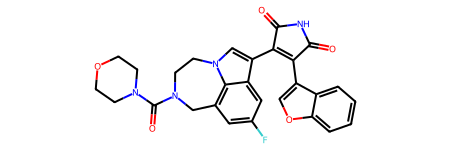

In [174]:
df_output.ROMol.iloc[0]

## Guardar el dataframe obtenido

Se va a guardar el dataframe como un archivo csv

In [175]:
df_output.to_csv(f"data/compounds_{uniprot_id}_full.csv", index=0)

## Actividad práctica
Teniendo en cuenta lo aprendido en este Notebook, responda:
1. ¿Qué otros datos podemos obtener de ChEMBL del target de interés?
2. ¿Se podría realizar una nueva clasificación de los compuestos filtrándolos únicamente por el pEC50?, compruébelo y observe las diferencias
3. Obtenga los datos conocidos de los compuestos, referentes a inhibición y actividad.

## Conclusiones
En esta práctica se empleó la base de datos ChEMBL para obtener datos de compuestos bioactivos frente a nuestro target de interés. Estos datos extraidos en forma de diccionarios y listas se convirtieron en un DataFrame el cual permite visualizar fácilmente la información obtenida. Además, se obtuvieron datos de los compuestos bioactivos, combinaron DataFrames, se renombraron columnas y se utilizo una herramienta de panda para añadir una nueva columna al DataFrame construido.